In [1]:
import polytope as pc
from collections import OrderedDict
import numpy as np

prob = {}
prob['rov_T'] = 15
prob['cop_T'] = 30
prob['rov_x0'] = np.array([0.5, -4.5])
prob['cop_x0'] = np.array([-0.5, -4.5, 2])
prob['cop_xT'] = np.array([4.5, -4.5, 2])
prob['cop_sight'] = 2
prob['weak_accu'] = 0.85
prob['prob_margin'] = 0.1

prob['formula'] = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( sampleC ) )'

regs = OrderedDict()

regs['r1'] = (pc.box2poly(np.array([[2, 3], [0, 5]])), 0.5, 'red')
regs['r2'] = (pc.box2poly(np.array([[-3, -2], [1, 5]])), 1, 'red')
regs['r3'] = (pc.box2poly(np.array([[-5, -3], [0, 1]])), 0.5, 'red')
regs['a1'] = (pc.box2poly(np.array([[-1, 1], [4, 5]])), 0.5, 'green')
regs['b1'] = (pc.box2poly(np.array([[4, 5], [4, 5]])), 0.5, 'blue')
regs['c1'] = (pc.box2poly(np.array([[-5, -4], [4, 5]])), 0.5, 'blue')

prob['regs'] = regs
prob['env_Nlist'] = [1 if  reg[1] in [0,1] else 5 for reg in regs.itervalues()]
prob['env_x0'] = [0 if  reg[1] in [0,1] else 2 for reg in regs.itervalues()]

In [2]:
# plot workspace
from best.abstraction import Abstraction
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import best.rss18_functions as rf

# rover model
rover_abstr = Abstraction([-5, -5], [5, 5], [10, 10])

fig = plt.figure(figsize=(5, 5))
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abstr.plot(ax)

for name, info in regs.iteritems():
    rf.plot_region(ax, info[0], name, info[1], info[2])
    
ax.text(prob['rov_x0'][0]+0.1, prob['rov_x0'][1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle(  prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))
ax.text( prob['cop_x0'][0]+0.1, prob['cop_x0'] [1]+0.1, '$\\xi_c^0$')

fig.savefig('exp2-workspace.pdf')

In [3]:
# create systems
from best.mdp import ParallelMDP

# rover MDP
rover = rover_abstr.abstract()
rover.input_name = 'ar'
rover.output_name = 'xr'
print rover

# copter model
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2])
copter = copter_abstr.abstract()
copter.input_name = 'ac'
copter.output_name = 'xc'
print copter

# Environment belief model
env = ParallelMDP([rf.environment_belief_model(info[1], [1-prob['weak_accu'], prob['weak_accu']], name) for (name, info) in regs.iteritems()])
print env

# connect rover-env
rover_env_mdp = rover.product(env, connection=rf.get_conn_rov_env(prob['regs']) )
print rover_env_mdp

# Connect copter-env
mdp_copt_env = copter.product(env, connection=rf.get_conn_copt_env(prob['regs'], prob['cop_sight']) )
print mdp_copt_env

print 'MDP totals: {}, {}'.format(rover_env_mdp.N * 3 ,mdp_copt_env.N)

MDP: 5 inputs "ar" --> 100 outputs "xr"
MDP: 7 inputs "ac" --> 200 outputs "xc"
MDP: 243 inputs "(r1_u, r2_u, r3_u, a1_u, b1_u, c1_u)" --> 3125 outputs "(r1_b, r2_b, r3_b, a1_b, b1_b, c1_b)"
MDP: 5 inputs "ar" --> 312500 outputs "(xr, (r1_b, r2_b, r3_b, a1_b, b1_b, c1_b))"
MDP: 7 inputs "ac" --> 625000 outputs "(xc, (r1_b, r2_b, r3_b, a1_b, b1_b, c1_b))"
MDP totals: 937500, 625000


In [4]:
# solve rover LTL problem
from best.ltl import solve_ltl_cosafe

rover_ltlpol = solve_ltl_cosafe(rover_env_mdp, prob['formula'], rf.get_ltl_connection(regs),
                                horizon=prob['rov_T'], verbose=True)

# copter problem

# set up target set
init_rov = rover_abstr.x_to_s(prob['rov_x0'])
init_dfsa = rover_ltlpol.dfsa_init
v_max = np.max(rover_ltlpol.val[0].flatten())

idx = np.logical_or(rover_ltlpol.val[0][init_rov, :, init_dfsa] > v_max-prob['prob_margin'],
                    rover_ltlpol.val[0][init_rov, :, init_dfsa] < prob['prob_margin'])

Vacc = np.zeros(mdp_copt_env.N_list)
Vacc[:, idx] = 1

end_cop = copter_abstr.x_to_s(prob['cop_xT'])

# constraint set (landing)
Vcon = np.zeros(mdp_copt_env.N_list)
Vcon[end_cop, :] = 1

val_copt_list, pol_copt_list = mdp_copt_env.solve_reach_constrained(Vacc, Vcon, 0.95, horizon=prob['cop_T'], verbose=True)

iteration 0, time 0.0102391242981
iteration 1, time 5.02968001366
iteration 2, time 8.5851650238
iteration 3, time 12.024764061
iteration 4, time 15.4931221008
iteration 5, time 19.0721101761
iteration 6, time 22.4287831783
iteration 7, time 25.8060669899
iteration 8, time 29.2638969421
iteration 9, time 32.7871670723
iteration 10, time 36.1199071407
iteration 11, time 39.4842970371
iteration 12, time 42.8974421024
iteration 13, time 46.1725599766
iteration 14, time 49.4547531605
finished after 52.671585083s and 15 iterations
iteration 0, time 4.05311584473e-06
iteration 1, time 2.12439513206
iteration 2, time 4.26139307022
iteration 3, time 6.43271207809
iteration 4, time 8.69319105148
iteration 5, time 10.865981102
iteration 6, time 13.1228539944
iteration 7, time 15.2278671265
iteration 8, time 17.2696800232
iteration 9, time 19.3566091061
iteration 10, time 21.4228601456
iteration 11, time 23.4793219566
iteration 12, time 25.7354550362
iteration 13, time 28.3670310974
iteration 14,

In [5]:
# save controllers
copter_policy = rf.CopterPolicy(pol_copt_list, val_copt_list, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)

if False:
    import cPickle as pickle
    with open('policies.pickle', 'wb') as fp:
      pickle.dump((copter_policy, rover_policy, prob), fp)

success probability: 0.25


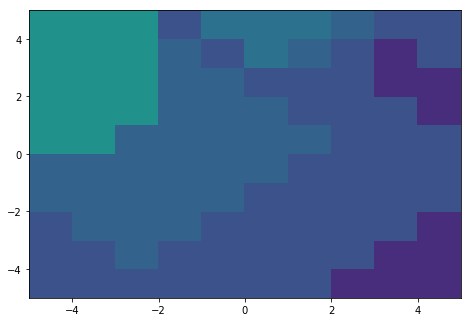

In [6]:
# plot rover value fcn
def my_value(x, mapstate):    
    s_abstr = rover_abstr.x_to_s(x)
    s_map = env.global_state(mapstate)

    _, val = rover_ltlpol((s_abstr, s_map))
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), prob['env_x0'])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print 'success probability: {}'.format(my_value(prob['rov_x0'], prob['env_x0']))

success value: 0.688906252384


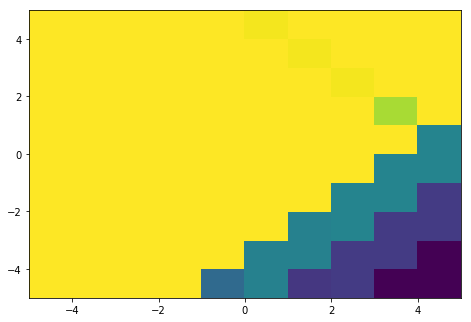

In [7]:
# plot copter value fcn
map_init = env.global_state(prob['env_x0'])

def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    
    return val_copt_list[0][scop, mapstate]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), map_init)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print 'success value: {}'.format(copter_value(prob['cop_x0'], map_init))

exploration ends at t=26.0
mission ends at t=38.4
exploration ends at t=26.6
mission ends at t=39.9
exploration ends at t=21.7
mission ends at t=21.7
exploration ends at t=26.0
mission ends at t=26.0


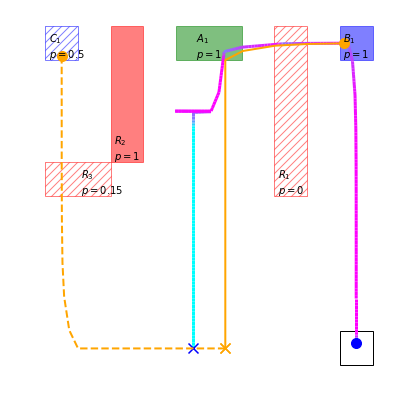

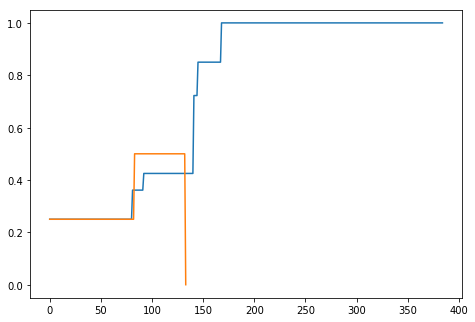

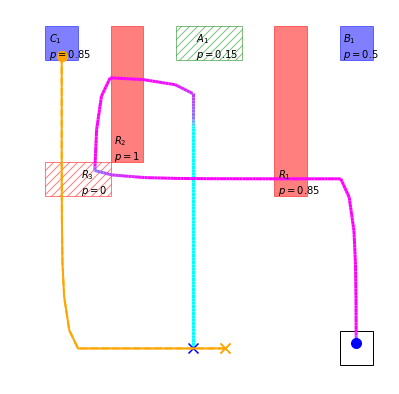

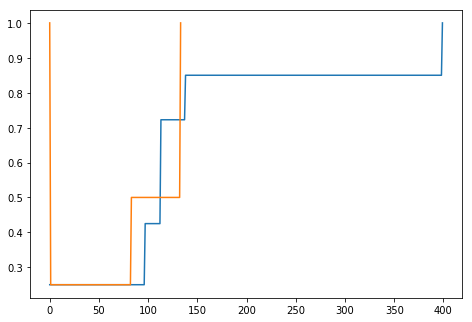

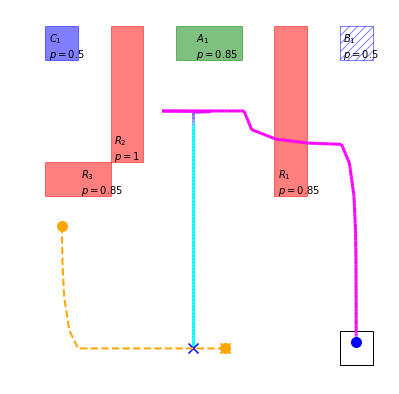

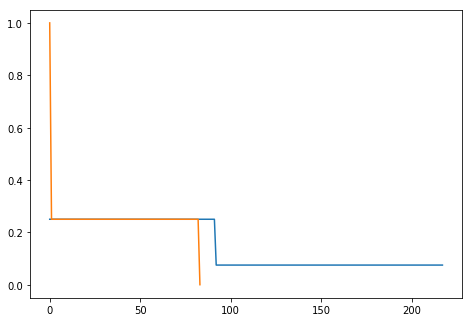

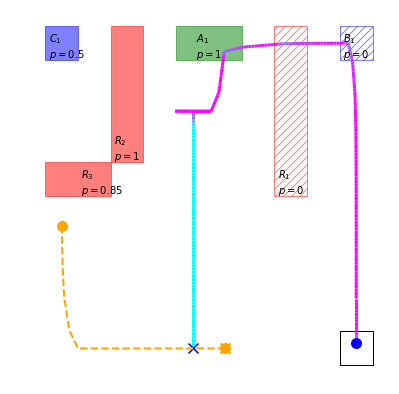

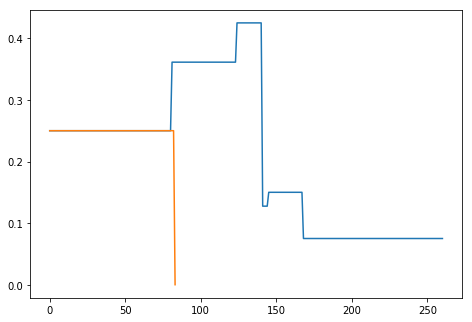

In [8]:
# Simulations
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from best import midx_to_idx

copter_policy = rf.CopterPolicy(pol_copt_list, val_copt_list, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)

conn_copt_env = rf.get_conn_copt_env(prob['regs'], prob['cop_sight'])
conn_rov_env = rf.get_conn_rov_env(prob['regs'])
conn_ltl = rf.get_ltl_connection(prob['regs'])

realmaps = ([0, 0, 0, 4, 4, 0], [4, 0, 0, 0, 4, 4], [4, 0, 4, 4, 0, 4], [0, 0, 4, 4, 0, 4])   # true map state

for exp_i in range(len(realmaps)):
    
    realmap = realmaps[exp_i][:]
    
    # ROVER ONLY
    x_rover_only = prob['rov_x0'].reshape((1,2))
    mapstate = prob['env_x0'][:]
    val_only = rover_policy.get_value(x_rover_only[-1,:].flatten(), midx_to_idx(mapstate, prob['env_Nlist']))
    psuccess_only = np.array([val_only])
    tvec_only = np.array([0])

    rover_policy.reset()

    while not rover_policy.finished() and val_only > 0.:
        
        x_curr = x_rover_only[-1, :].flatten()
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]
        x_map = midx_to_idx(mapstate, prob['env_Nlist'])
        
        aps = conn_ltl((x_curr, env.output(x_map)))
        x_next, val_only = rover_policy(x_curr, x_map, list(aps)[0])

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
        x_rover_only = np.vstack([x_rover_only, x_del])
            
        psuccess_only = np.hstack([psuccess_only, val_only])
        tvec_only = np.hstack([tvec_only, tvec_only[-1] + 0.1])

    
    # COPTER AND ROVER
    mapstate = prob['env_x0'][:]

    rover_policy.reset()
    copter_policy.reset()

    # copter simulation
    x_copter = prob['cop_x0'].reshape((1,3))
    x_rover = prob['rov_x0'].reshape((1,2))
  
    val = rover_policy.get_value(x_rover[-1,:].flatten(), midx_to_idx(mapstate, prob['env_Nlist']))

    psuccess = np.array([val])
    tvec = np.array([0])
    
    while not copter_policy.finished():

        x_curr = x_copter[-1, :].flatten()

        map_meas = list(conn_copt_env(x_curr))[0]

        for i in range(len(map_meas)):
            if mapstate[i] in [0, 4]:
                continue
            if map_meas[i] == 1:  # weak meas
                if realmap[i] == 4:
                    mapstate[i] = 3
                else:
                    mapstate[i] = 1
            if map_meas[i] == 2:
                mapstate[i] = realmap[i]
        x_map = midx_to_idx(mapstate, prob['env_Nlist'])
        x_next, _ = copter_policy(x_curr, x_map)

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
            x_copter = np.vstack([x_copter, x_del])
        else:
            x_copter = np.vstack([x_copter, x_curr])
        
        val = rover_policy.get_value(x_rover[-1,:].flatten(), x_map)
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])

    mid_probs = env.output(env.global_state(mapstate[:]))
    
    expl_endtime = tvec[-1]
    print 'exploration ends at t={}'.format(expl_endtime)
    
    # rover simulation
    it = 0
    
    while not rover_policy.finished() and val > 0.1:
        
        x_curr = x_rover[-1, :].flatten()
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]
        x_map = midx_to_idx(mapstate, prob['env_Nlist'])
        
        aps = conn_ltl((x_curr, env.output(x_map)))
        x_next, val = rover_policy(x_curr, x_map, list(aps)[0])

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
        x_rover = np.vstack([x_rover, x_del])
            
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])
    
    print 'mission ends at t={}'.format(tvec[-1])

    
    # PLOTTING
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    ax.axis('off')
    fig.add_axes(ax)
    
    i = 0
    for (name, info) in prob['regs'].iteritems():
        if realmap[i] == 0 and info[1] != 1:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        rf.plot_region(ax, info[0], name, '{}'.format(mid_probs[i]), info[2], hatch=hatch, fill=fill)
        i += 1
        
    points = np.array([x_copter[:,0], x_copter[:,1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('cool'))
    lc.set_array(x_copter[:, 2])
    lc.set_linewidth(3)
    ax.add_collection(lc)
    
    ax.scatter(x_copter[0, 0], x_copter[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter[-1, 0], x_copter[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover_only[:, 0], x_rover_only[:, 1], '--', color='orange', linewidth=2)
    ax.scatter(x_rover_only[0, 0], x_rover_only[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover_only[-1, 0], x_rover_only[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.plot(x_rover[:, 0], x_rover[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover[0, 0], x_rover[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover[-1, 0], x_rover[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.add_patch(patches.Rectangle( prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))

    fig.savefig('exp2-{}-trajectory.pdf'.format(exp_i))

    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    ax.plot(psuccess)
    ax.plot(psuccess_only)

    np.savetxt('exp2-{}-proba.txt'.format(exp_i),  np.vstack([psuccess, tvec]).T, delimiter=' ')
    np.savetxt('exp2-{}-proba-only.txt'.format(exp_i),  np.vstack([psuccess_only, expl_endtime+tvec_only]).T, delimiter=' ')